**SETTLEMENT OF PILES WITH NEGATIVE SKIN FRICTION:
DESIGN APPROACHES FOLLOWING NEW EUROCODE 7**

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from scipy import stats

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [ ]:
# EXAMPLES / INPUT DATA
################################################################################

# SOLVER

# thickness of soil layers (for settlement) and pile element length [m]: height_e = []

# SURFACE SURCHARGE [m*kN/m^3 = kPa]: surcharge = []

# SOIL PROFILE

# soil type: (pile head > toe): soil_i = np.array([], dtype=object)
# weak rocks: R3, R4, R5, sand and gravel S,G according to ID: D05, D07, D09, fine soils F according to IC: C050, C075, C100, non-bearing soil Y

# soil layer thicknesses (pile head > toe) [m]:  height_i = np.array([])

# unit weight of soil [kN/m^3]: gamma_i = np.array([])

# deformation modulus [MPa]: Edef_i = np.array([])

# parameter beta (Edef >> Eoed) [-]: betaE_i = np.array([])

# structural stiffnes parameter [m]: mst_i = np.array([])

# PILE GEOMETRY AND MATERIAL

# pile diameter (pile head > toe) [m]: diam_i = np.array([])

# parameter reflecting pile installation and insulation [-]: m = []
# 1.0 Unsupported excavations, concreting in a dry borehole or under the water level
# 0.9 Excavations under excavation-support fluids
# 0.7 Piles with secondary shaft insulation made of PVC or PE foils with thickness > 0.7 mm
# 0.5 Piles with secondary shaft insulation made of PVC foil and wire netting,
# 0.15 Piles with the permanent casting of steel tubes

# Young's modulus of concrete (pile) [MPa]: Epile = []

# force at pile head [kN]: R_user = []

# set example number
ex_number = 1

# element size
height_e = 0.02 # m

# NO ground water
h_GWL = 50 # no influence
gamma_w = 10


match ex_number:
  case 1:
    # Example / clay C050, R5
    surcharge = 100
    soil_i = np.array(['C050', 'R5'], dtype=object)
    height_i = np.array([14, 1])
    gamma_i = np.array([20, 21])
    Edef_i = np.array([15, 100])
    betaE_i = np.array([0.47, 0.83])
    mst_i = np.array([0.2, 0.3])
    diam_i = np.array([0.8, 0.8])
    m = 1
    Epile = 30000
    R_user = 1600
    scale_qb = 1.4285
  case 2:
    # Example / sand, clay C050, R5
    surcharge = 100
    soil_i = np.array(['D05', 'C050', 'R5'], dtype=object)
    height_i = np.array([5, 14, 1])
    gamma_i = np.array([19, 20, 21])
    Edef_i = np.array([30, 15, 100])
    betaE_i = np.array([0.74, 0.47, 0.83])
    mst_i = np.array([0.3, 0.2, 0.3])
    diam_i = np.array([0.8, 0.8, 0.8])
    m = 1
    Epile = 30000
    R_user = 1900
    scale_qb = 1.4285
  case _:
    # If an exact match is not confirmed, this last case will be used if provided
    print("Missing inputs.")


In [ ]:
## GEOMETRY AND OTHER PARAMETERS / CALCULATION
################################################################################
# pile length
L = np.sum(height_i)
print('L', L)

# cross-sectional area - layers
Ai = np.pi*diam_i**2/4
print('Ai', Ai)

# cross-sectional area - weighted average
A_avg = np.sum(Ai*height_i)/np.sum(height_i)
print('avg Ai', A_avg)

# diameter - weighted average
d_avg = np.sum(diam_i*height_i)/np.sum(height_i)
print('avg diam_i', d_avg)

# distance from the pile head to the middle of the i-th layer
Di = []
zdown = 0
for index_height_i, value_height_i in enumerate(height_i):
  D = zdown + 0.5*value_height_i
  Di.append(D)
  zdown = zdown + value_height_i
print('Di = ', Di)

# oedometric modulus [MPa]:
Eoedi = Edef_i/betaE_i
print('Eoed = ', Eoedi)

L 15
Ai [0.50265482 0.50265482]
avg Ai 0.5026548245743669
avg diam_i 0.8000000000000002
Di =  [7.0, 14.5]
Eoed =  [ 31.91489362 120.48192771]


In [ ]:
# table of regression coefficients [kPa]

RS = {'R3': np.array([246.02, 225.95, 2841.31, 1298.96]),  # poloskalní	R 3 R 4 R 5
      'R4': np.array([169.98, 139.45, 1616.22, 1155.34]),
      'R5': np.array([131.92, 94.96, 957.61,	703.89]),
      'D05': np.array([62.46, 16.06, 268.11, 174.89]),  # hrubozrnné ID = 0,5 ID = 0,7 ID = 0,9
      'D07': np.array([91.22, 48.44, 490.34, 445.42]),
      'D09': np.array([154.03,	115.88, 1596.70, 1399.88]),
      'C050': np.array([46.39, 20.81, 197.74, 150.22]),  # jemnozrnné	IC = 0,5 IC = 0,75 IC ≥ 1,0
      'C075': np.array([71.85, 64.70, 592.67, 617.24]),
      'C100': np.array([97.31, 108.59, 987.60, 1084.26]),
      'Y':np.array([0, 0, 0, 0])}

# table of secant modulus of deformation [MPa]

h_Es = np.array([1.5, 3.0, 5.0, 10.0])
d_Es = np.array([0.6, 1.0, 1.5])
Es = {'R3' : np.array([[50.3, 72.3, 85.5],[64.5, 105.5, 138.3],[64.5, 105.5, 138.3],[64.5, 105.5, 138.3]]),
      'R4': np.array([[28.2, 35.0, 33.5],[43.1, 57.3, 58.8],[58.2, 75.3, 87.9],[87.5, 114.5, 133.0]]),
      'R5': np.array([[20.2, 24.7, 22.3],[30.8, 41.0, 41.2],[41.3, 54.8, 63.7],[61.6,	83.2,	97.0]]),
      'D05': np.array([[11.0, 12.8, 13.0],[15.5, 18.4, 19.4],[18.8, 22.8, 24.5],[23.8, 29.8,	32.6]]),
      'D07': np.array([[13.7, 15.8, 15.3],[20.2, 25.0, 24.5],[26.6, 32.5, 36.0],[36.6,	47.8, 54.0]]),
      'D09': np.array([[28.3, 30.6, 29.0],[44.5, 47.8, 52.5],[56.1, 69.1, 78.2],[72.1,	93.4, 107.3]]),
      'C050': np.array([[6.9, 7.9, 8.6],[10.0, 12.5, 13.7],[12.5, 15.9, 18.4],[15.5,	21.3,	24.6]]),
      'C075': np.array([[10.0, 10.7, 10.5],[15.5, 18.6, 18.4],[21.9, 25.7, 27.6],[29.9,	36.3, 41.0]]),
      'C100': np.array([[13.2, 13.4, 12.3],[22.0, 23.9, 23.0],[31.2, 35.4, 36.7],[44.3,	51.3,	57.4]]),
      'Y':np.array([[0, 0, 0],[0, 0, 0],[0, 0, 0],[0, 0, 0]])}


# basic influence factor of pile settlement I1

I1_tabM = np.array([[0.25, 0.6, 1.2, 2.2, 3, 5, 10, 17, 20],[0.7, 0.5, 0.4, 0.3, 0.25, 0.2, 0.14, 0.1, 0.09]])
I1_tab = np.array([[0.097774726, 0.508166969, 0.877519988, 2.478049738, 4.324814833,
                    5.43287389, 6.787168294, 8.387698043, 10.23446314, 12.45058125,
                    15.03605239, 17.74464119, 20.41219078, 23.16181881, 25.87040761,
                    28.57899642, 31.28758523, 33.99617403, 36.70476284, 42.12194045,
                    44.83052926, 47.51449453, 49.50900083, 1.633393829, 3.35753176, 39.38294011],
                     [0.693354275, 0.581581237, 0.490352944, 0.326977214, 0.239998397,
                      0.206839791, 0.179771487, 0.156080105, 0.136378778, 0.119340748,
                      0.104477601, 0.093003517, 0.08472081, 0.07712232, 0.071209049,
                      0.066297801, 0.061999442, 0.058334157, 0.054976848, 0.049210969,
                      0.046752773, 0.044279788, 0.042534245, 0.400016778, 0.276776525, 0.052060359]])

# correction factor Rk
# value subtracted from the nearest higher curve

Rk_tab = { 1 : np.array([[10.067356592740158, 13.894954943731374, 20.235896477251565, 30.6817739892608, 49.417133613238335, 83.4224228232509, 131.68415694603644, 217.86748488023989, 10000],
                         [1.1087202718006792, 1.090600226500566, 1.0634201585503962, 1.043035107587769, 1.0249150622876555, 1.0158550396375992, 1.0113250283125703, 1.0067950169875424, 1]]),
           2 : np.array([[10.481131341546858, 13.894954943731374, 18.420699693267164, 25.59547922699536, 35.32685341440873, 49.086503649701214, 70.06176107528361, 102.03433907304515,
                          144.66046415316774, 213.52368904381416, 10000],
                         [1.2287655719139297, 1.1789354473386182, 1.1404303510758778, 1.1087202718006792, 1.086070215175538, 1.0634201585503962, 1.047565118912797, 1.0317100792751983,
                          1.0226500566251415, 1.0113250283125703, 1]]),
           5 : np.array([[10.411006350073151, 13.080311175328532, 16.10634822827887, 21.352368904381418, 31.729097990236276, 44.384396663290566, 67.29585855529835, 102.72160761529055,
                          154.7050082066822, 250.85161975393245, 395.9748823866281, 572.8191027904562, 801.2906727567666, 10000],
                         [1.5571913929784824, 1.4756511891279727, 1.4167610419026047, 1.3556058890147225, 1.2853907134767835, 1.233295583238958, 1.1789354473386182, 1.1336353340883352,
                          1.09286523216308, 1.0634201585503962, 1.0385050962627402, 1.0226500566251415, 1.0113250283125703, 1]]),
           10 : np.array([[10.55172867106972, 11.987184813832657, 14.273121095621159, 16.768329368110084, 19.966021994264466, 23.614450413867154, 28.882940089826537, 35.564803062231285,
                           47.78595739422061, 61.259297429263256, 81.21214685003928, 104.81131341546863, 144.66046415316774, 219.33496602527995, 308.88435964774817, 471.48663634573944,
                           739.2726930837066, 1198.7184813832657, 1547.0500820668221, 10000],
                          [2.2887882219705546, 2.2072480181200453, 2.0962627406568517, 2.003397508493771, 1.9060022650056623, 1.8131370328425818, 1.713476783691959, 1.6183465458663644,
                           1.507361268403171, 1.421291053227633, 1.3442808607021515, 1.2899207248018119, 1.2287655719139297, 1.1698754246885616, 1.1291053227633066, 1.090600226500566,
                           1.0520951302378254, 1.020385050962627, 1, 1]]),
           25 : np.array([[25.424230274561797, 28.307078138811278, 31.51681148665876, 35.564803062231285, 39.332557532746605, 44.384396663290566, 50.42244567111142, 57.66774170924995,
                           64.63914850539453, 75.43120063354615, 86.8511373751353, 104.11006350073146, 125.63925844917594, 155.7470484299462, 194.3702250946123, 234.56455720358792,
                           298.6886079915058, 409.49150623804275, 539.2354377551928, 719.685673001152, 1013.516687653887, 1506.0610109031597, 2345.6455720358795, 3933.255753274661,
                           6084.943635893364, 9800.622114914786, 10000],
                          [2.9886749716874292, 2.8958097395243487, 2.8052095130237826, 2.7032842582106453, 2.614949037372593, 2.5130237825594564, 2.4065685164212907, 2.3001132502831254,
                           2.2072480181200453, 2.0939977349943373, 2.0011325028312568, 1.8856172140430352, 1.7814269535673837, 1.6727066817667042, 1.5753114382785955, 1.4983012457531144,
                           1.4167610419026047, 1.3284258210645525, 1.2604756511891277, 1.203850509626274, 1.1494903737259343, 1.0996602491506227, 1.0611551528878822, 1.0317100792751983,
                           1.0158550396375992, 1.0090600226500563, 1]]),
           50 : np.array([[86.8511373751353, 95.40954763499944, 107.66386610307008, 120.67926406393289, 132.57113655901082, 149.59845685700847, 167.68329368110082, 189.22038858908928,
                           213.52368904381416, 245.8501932122585, 283.0707813881125, 328.12172452166294, 382.9044194874126, 468.3321108201742, 557.6422683489906, 734.3265198501232,
                           928.8167295076223, 1120.8891936724888, 1456.348477501243, 2050.9418769330955, 2966.902038683106, 4438.439666329056, 6595.412795992344, 9735.050134195395,
                           10000],
                          [2.9977349943374856, 2.909399773499434, 2.8052095130237826, 2.7032842582106453, 2.614949037372593, 2.508493771234428, 2.4065685164212907, 2.304643261608154,
                           2.2072480181200453, 2.103057757644394, 2.0011325028312568, 1.9037372593431483, 1.8154020385050962, 1.7066817667044167, 1.6206115515288788, 1.5050962627406568,
                           1.4190260475651189, 1.3624009060022648, 1.2876557191392977, 1.208380520951302, 1.1426953567383917, 1.0883352208380521, 1.047565118912797, 1.0226500566251415,
                           1]])}

# table of input parameters for nonlinear fitting / program Pilota + Es pres. modul [MPa]
# a, fa, A, X, Z
NS = {'R3': np.array([0.66, 3.02, 400, 3.7, 2.67, 80]),  # poloskalní	R 3 R 4 R 5
      'R4': np.array([0.66, 3.02, 280, 2.6, 1.89, 50]),
      'R5': np.array([0.66, 3.017, 200, 1.7, 1.25, 30]),
      'D05': np.array([0.66, 3.2, 110, 0.53, 0.32, 10]),  # hrubozrnné ID = 0,5 ID = 0,7 ID = 0,9
      'D07': np.array([0.66, 3.017, 140, 1.15, 0.69, 20]),
      'D09': np.array([0.66, 3.2, 220, 1.82, 1.09, 40]),
      'C050': np.array([0.5, 4.5, 90, 0.36, 0.26, 8]),  # jemnozrnné	IC = 0,5 IC = 0,75 IC ≥ 1,0
      'C075': np.array([0.5, 4.5, 125, 0.85, 0.62, 15]),
      'C100': np.array([0.5, 4.5, 150, 1.35, 0.98, 25]),
      'Y':np.array([1, 0, 0, 0, 0, 1])}

# ga /  program Pilota
ga = { 0.6: np.array([0, 5.668, 4.675, 2.997, 1.892, 1.055, 0.6]),
       0.8: np.array([0, 6.112, 5.141, 3.460, 2.287, 1.102, 0.8]),
       1.0: np.array([0, 6.462, 5.553, 3.869, 2.650, 1.417, 1.0]),
       1.2: np.array([0, 6.764, 5.877, 4.238, 2.989, 1.737, 1.2]),
       1.4: np.array([0, 7.029, 6.183, 4.577, 3.309, 2.034, 1.4]),
       1.6: np.array([0, 7.268, 6.462, 4.893, 3.614, 2.321, 1.6]),
       1.8: np.array([0, 7.485, 6.718, 5.190, 3.906, 2.612, 1.8]),
       2.0: np.array([0, 7.685, 6.956, 5.471, 4.188, 2.923, 2.0])}

key_ga_alpha = np.array([0, 0.25, 0.33, 0.50, 0.66, 0.8, 1])
key_ga_d = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])

In [ ]:
## TEST
################################################################################

# interpolate.interp1d(x, y, kind='linear', axis=-1, copy=True, bounds_error=None, fill_value=nan, assume_sorted=False)
inter_I1 = interpolate.interp1d(I1_tab[0], I1_tab[1])
x_new = np.linspace(I1_tab[0,0], np.amax(I1_tab[0]), 100)
y_new = inter_I1(x_new)

[xdata, ydata] = I1_tab

In [ ]:
## SOIL SETTLEMENT DUE TO THE SURFACE SURCHARGE
################################################################################

ni_set = np.rint(height_i/height_e)
h_j = []
soil_j = []
gamma_j = []
Eoed_j = []
m_st_j = []
D_j = []
sigma_or = []
sigma_z = []

zdown = 0
sig_or = 0

for index, value in enumerate(ni_set):
  thickness = height_i[index]/value
  for ind in range(0, int(value)):
    h_j.append(thickness)
    D_j.append(zdown + 0.5*thickness)
    soil_j.append(soil_i[index])
    if zdown < h_GWL:
      gamma = gamma_i[index]
    else:
      gamma = (gamma_i[index] - gamma_w)
      print('Influence of GWT')
    gamma_j.append(gamma)
    Eoed_j.append(Eoedi[index])
    m_st_j.append(mst_i[index])
    zdown = zdown + thickness
    sig_or = sig_or + 0.5*thickness*gamma
    struct_stiff = mst_i[index] * sig_or
    sigma_or.append(sig_or)
    sigma_z.append(surcharge)
    sig_or = sig_or + 0.5*thickness*gamma

# soil settlement below the pile toe
while (surcharge-struct_stiff) > 0:
  thickness = 0.5
  h_j.append(thickness)
  D_j.append(zdown + 0.5*thickness)
  gamma_j.append(gamma)
  Eoed_j.append(Eoedi[index])
  m_st_j.append(mst_i[index])
  zdown = zdown + thickness
  sig_or = sig_or + 0.5*thickness*gamma
  struct_stiff = mst_i[index] * sig_or
  sigma_z.append(surcharge)
  sigma_or.append(sig_or)
  sig_or = sig_or + 0.5*thickness*gamma

s_layer = (np.array(sigma_z) - np.array(m_st_j)*np.array(sigma_or))/np.array(Eoed_j)*np.array(h_j)

# reset negative values
s_layer [s_layer < 0] = 0
s_soil = [0]

for index, value in enumerate(s_layer):
  s_flip = np.flip(s_layer)
  s_soil.append(np.sum(s_flip[0:index+1]))
s_soil = np.flip(np.array(s_soil))
# print('layer settlement [mm]:', s_layer)
# print('soil settlement [mm]:', s_soil)

z_soil = np.concatenate((np.array([0]), np.array(D_j) + 0.5*np.array(h_j)))
# print('Dj', D_j[-1])
# print('type Dj', type(D_j[-1]))
# print('hj', h_j[-1])
# print('depth below the original terrain [m]:', z_soil[-1])
# print('depth below the original terrain [m]:', z_soil)

# plt.plot(s_soil, z_soil, 'k')
# plt.ylim([1.1*np.amax(z_soil), 0])
# plt.xlim([0, 1.1*np.amax(s_soil)])

 soil, a, b, e, f:  C050 46.39 20.81 197.74 150.22
 soil, a, b, e, f:  R5 131.92 94.96 957.61 703.89
q0=  920.0692
qsi=  [44.011714285714284, 126.68082758620689]
qs_avg=  49.52298850574712
Esi = [18.4, 22.450000000000003]
L/d0 =  18.75
beta=  0.19853495083476136
Rsu=  1306.8808777371223
Ry=  1630.614933362717
I1 =  0.08988189088878731
Es_avg = 18.669999999999998
K=  1606.855918585967
Rk =  1.0950375847963802
I =  0.09842404871578944
sy =  10.745294833823365
Rbu =  753.1995646284291
Rbu = 0.7*q0*A*25/sy =  753.1995646284291
Ai =  [0.50265482 0.50265482]
Ru =  2060.0804423655513
idOPT =  190
z_dOPT =  2.7400000000000015 2.7600000000000016


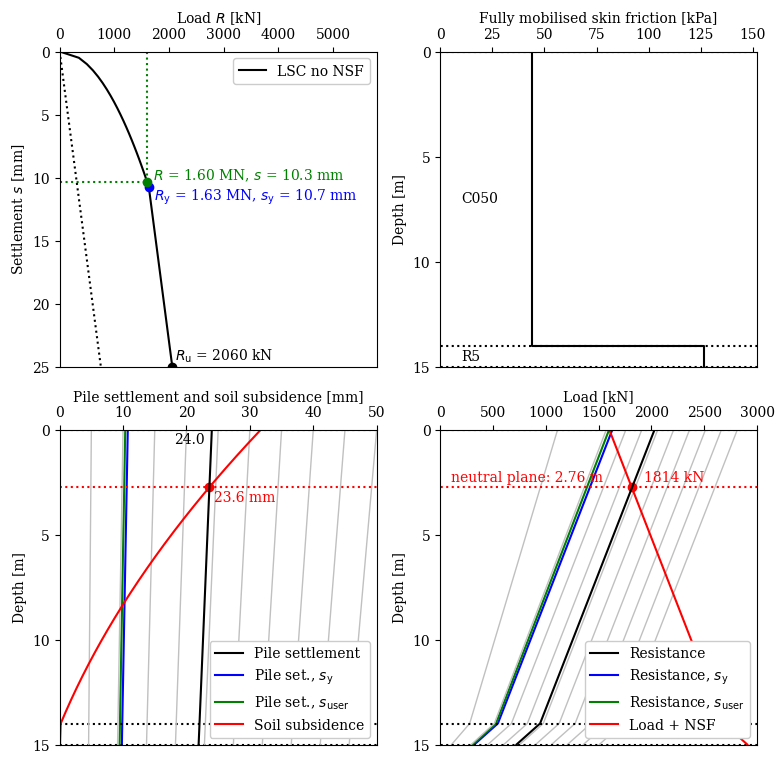

In [ ]:
## QUADRATIC-LINEAR APPROXIMATION OF THE LSC // METODA REGRESNICH SOUCINITELU
################################################################################

# regression coefficients TAB
RSi = []
# secant modulus TAB interpolation
Esi = []
# ultimate skin friction in the i-th layer of the pile
qsi = []

for index, value_height_i in enumerate(height_i):
  value_diam_i = diam_i[index]
  value_Di = Di[index]
  soil = soil_i[index]
  interpES = RegularGridInterpolator((h_Es, d_Es), Es[soil], method='linear', bounds_error=True)
  Esval = interpES([min(max(value_height_i, 1.5), 10), min(max(diam_i[index], 0.6), 1.5)])
  Esi.append(Esval[0])
  [a, b, e, f] = RS[soil]
  print(' soil, a, b, e, f: ', soil, a, b, e, f)
  qs = a - b / (value_Di/value_diam_i)
  qsi.append(max(qs,0))
  # stress at the base of the pile corresponding to the full mobilization of skin friction
  d0 = value_diam_i
  q0 = e - f / (L/d0)

print('q0= ', q0)
print('qsi= ', qsi)
# the average magnitude of skin friction along the pile shaft as a weighted average of the qsi values
qs_avg = np.sum(diam_i*height_i*qsi)/np.sum(diam_i*height_i)
print('qs_avg= ', qs_avg)
print('Esi =', Esi)

# pile slenderness
slend = L/d0
print('L/d0 = ', slend)

# coefficient of load transfer to the base of the pile β
beta = q0 / (q0 + 4*qs_avg*L/d0)
print('beta= ', beta)

# ultimate load capacity on the pile shaft

Rsu = 0.7*m*np.pi*np.sum(diam_i*height_i*qsi)
print('Rsu= ', Rsu)

# Load in the pile head corresponding to the full mobilization of skin friction
Ry = Rsu/(1-beta)
print('Ry= ', Ry)

# coeficient I1
inter_I1 = interpolate.interp1d(I1_tab[0], I1_tab[1])
I1 = inter_I1(slend)
print('I1 = ', I1)

# the average magnitude of the secant modulus of deformation along the pile shaft
Es_avg = np.sum(Esi*height_i)/np.sum(height_i)
print('Es_avg =', Es_avg)

# coeficient Rk
# taken from the nearest higher curve
K = Epile/Es_avg
print('K= ', K)
key_Rk = []
for key, value in Rk_tab.items():
  key_Rk.append(key)
key_Rk = np.array(key_Rk)
Ukey = key_Rk[key_Rk > slend].min()
inter_Rk = interpolate.interp1d(Rk_tab[Ukey][0], Rk_tab[Ukey][1])
Rk = inter_Rk(K)
# OR SET ITS VALUE BY HAND
# Rkr =
print('Rk = ', Rk)

# plt.plot(, label=('L/d = ' + str(key)))

# coeficient I
I = I1*Rk
# OR SET ITS VALUE BY HAND
# I =
print('I = ', I)

# setllement for Rsy
sy = I*Ry/d_avg/Es_avg
# sy = I*Ry/d_avg/Es_avg/0.7
print('sy = ', sy)

# load-bearing capacity of pile toe for settlement 25 mm
Rbu = beta * Ry * 25 / sy
print('Rbu = ', Rbu)
# check
Rbu2 = 0.7*q0*Ai[-1]* 25 / sy
print('Rbu = 0.7*q0*A*25/sy = ', Rbu2)

print('Ai = ', Ai)

# load-bearing capacity for settlement 25 mm
Ru = Rbu + Rsu
print('Ru = ', Ru)

# ultimate loading curve
# R = np.linspace(0, Ru, 1000)
s = np.linspace(0, 50.0, 101)

R_rs = []
for index, si in enumerate(s):
  if si < sy: R = (si/sy)**0.5*Ry
  else: R = Ry + (si-sy)*(Ru-Ry)/(25-sy)
  R_rs.append(R)

if R_user < Ry: s_user = sy*(R_user/Ry)**2
else: s_user = sy + (25-sy)*(R_user-Ry)/(Ru-Ry)

# Data for plots
################################################################################
# Round a number upward to its nearest integer math.ceil()
s_pile = np.linspace(5, 50.0, (451))
s_pile_int = np.linspace(5, 50.0, (10))
sb_pile = s_pile/Rk

z_inter = np.concatenate((np.array([0]), Di + height_i/2))
z_soil = np.concatenate((np.array([0]), np.array(D_j) + 0.5*np.array(h_j)))
inter_soil = interpolate.interp1d(z_soil, s_soil)
z_top = Di - height_i/2
z_bottom = Di + height_i/2
z_plot = np.concatenate((z_top, z_bottom))
z_plot = np.sort(z_plot)
qsi_plot = qsi
qsi_plot = np.repeat(qsi_plot, 2)

# load
load = [R_user]
R_load = R_user

# resistance Ry
resistance_Ry = [Ry]
R_res = Ry
Delta_R = []
for index, qs in enumerate(qsi):
  thick = height_i[index]
  diam = diam_i[index]
  # NSF = 70% FSF, FSF * 0.7 >> pile shaft resistance
  DR = 0.7*qs*thick*diam*np.pi
  Delta_R.append(DR)
  R_load = R_load + 0.7*qs*thick*diam*np.pi
  load.append(R_load)
  R_res = R_res - 0.7*qs*thick*diam*np.pi
  resistance_Ry.append(R_res)

# resistance Ruser
if s_user < sy:
  coef = (R_user - q0*A_avg*s_user/sy)/(Ry-q0*A_avg)
else: coef = 1
resistance_user = (resistance_Ry - Ry)*coef + R_user

# intersections of settlements and forces
Z_dS = []
for index, value in enumerate(s_pile):
  inter_pile = interpolate.interp1d([0, L], [s_pile[index], sb_pile[index]])
  z_cut = z_soil[z_soil < L+height_e]
  # print('z_cut = ', z_cut[-1])
  soil_fine = inter_soil(z_cut)
  pile_fine = inter_pile(z_cut)
  idS = np.argwhere(np.diff(np.sign(soil_fine - pile_fine))).flatten()
  z_dS = z_soil[idS]
  if z_dS.size > 0:
    Z_dS.append(z_dS[0])
  else:
    Z_dS.append(1e5)
# print('Z_dS = ', Z_dS)

Z_dF = []
for index, val_s in enumerate(s_pile):
  if val_s < sy:
    R_res = (val_s/sy)**0.5*Ry
    coef = (R_res - q0*A_avg*val_s/sy)/(Ry-q0*A_avg)
  else:
    R_res = Ry + (val_s-sy)*(Ru-Ry)/(25-sy)
    coef = 1
  Rt = R_res
  resistance = [R_res]
  for index, qs in enumerate(qsi):
    thick = height_i[index]
    diam = diam_i[index]
    R_res = R_res - 0.7*qs*thick*diam*np.pi*coef
    resistance.append(R_res)
  # print('Rres-Rbu/25*s', R_res-Rbu/25*val_s)
  inter_res = interpolate.interp1d(z_inter, resistance)
  inter_load = interpolate.interp1d(z_inter, load)
  z_cut = z_soil[z_soil < L]
  res_fine = inter_res(z_cut)
  load_fine = inter_load(z_cut)
  idF = np.argwhere(np.diff(np.sign(res_fine - load_fine))).flatten()
  z_dF = z_soil[idF]
  if z_dF.size > 0:
    Z_dF.append(z_dF[0])
  else:
    Z_dF.append(2e5)
# print('Z_dF = ', Z_dF)

idOPT = np.argmin(np.abs(np.array(Z_dF) - np.array(Z_dS)))
print('idOPT = ', idOPT)
z_dOPT1 = Z_dS[idOPT]
z_dOPT2 = Z_dF[idOPT]
print('z_dOPT = ', Z_dS[idOPT], Z_dF[idOPT])

# Plot results
################################################################################

fig, axs = plt.subplots(2, 2, figsize=(9, 9))

axs[0, 0].plot(R_rs, s, 'k', label='LSC no NSF')
axs[0, 0].plot([Ry], [sy], 'ob')
text= r'$R_\mathrm{{y}}$ = {:.2f} MN, $s_\mathrm{{y}}$ = {:.1f} mm'.format(Ry/1000, sy)
axs[0, 0].annotate(text, (Ry+100, sy+1), color='blue')
# axs[0, 0].plot([0, Ry], [sy, sy], 'b:')
# axs[0, 0].plot([Ry, Ry], [0, sy], 'b:')
axs[0, 0].plot([R_user], [s_user], 'og')
text= r'$R$ = {:.2f} MN, $s$ = {:.1f} mm'.format(R_user/1000, s_user)
axs[0, 0].annotate(text, (R_user+100, s_user-0.2), color='green')
axs[0, 0].plot([0, R_user], [s_user, s_user], 'g:')
axs[0, 0].plot([R_user, R_user], [0, s_user], 'g:')
axs[0, 0].plot([Ru], [25], 'ok')
# text= r'$R_\mathrm{{u}}$ = {:.0f} kN, $s_\mathrm{{u}}$ = {:.1f} mm'.format(Ru, 25)
text= r'$R_\mathrm{{u}}$ = {:.0f} kN'.format(Ru)
axs[0, 0].annotate(text, (Ru+50, 25-0.5), color='black')
axs[0, 0].plot([0, beta*Ry, Rbu], [0, sy, 25], ':k')
axs[0, 0].set_xlim([0, 5800])
axs[0, 0].set_ylim([25, 0])
# axs[0, 0].grid(True)
axs[0, 0].set_xlabel(r'Load $R$ [kN]')
axs[0, 0].set_ylabel(r'Settlement $s$ [mm]')
# axs[0, 0].set_title(r'Load-settlement curve without NSF')
axs[0, 0].legend(loc='upper right', framealpha=1)

axs[0, 1].plot(qsi_plot, z_plot, 'k')
axs[0, 1].set_ylim([L, 0])
axs[0, 1].set_xlim([0, 1.2*np.max(qsi_plot)])
axs[0, 1].set_xlabel(r'Fully mobilised skin friction [kPa]')
axs[0, 1].set_ylabel(r'Depth [m]')
# axs[0, 1].set_title(r'Fully mobilised skin friction')

for index, value in enumerate(z_inter):
  axs[0, 1].plot([-1e6, 1e6], [value, value], ':k')

for index, value_height_i in enumerate(height_i):
  value_Di = Di[index]
  text = soil_i[index]
  axs[0, 1].annotate(text, (10, value_Di+0.2))

axs[1, 0].plot(-10, -10, 'black', label='Pile settlement')
axs[1, 0].plot([sy, sy/Rk], [0, L], 'b', label=r'Pile set., $s_\mathrm{y}$')
axs[1, 0].plot([s_user, s_user/Rk], [0, L], 'g', label=r'Pile set., $s_\mathrm{user}$')

for index, value in enumerate(z_inter):
  axs[1, 0].plot([-1e6, 1e6], [value, value], ':k')

for index, value in enumerate(s_pile):
  if value in s_pile_int:
    axs[1, 0].plot([s_pile[index], sb_pile[index]], [0, L], 'silver', linewidth=1)

axs[1, 0].plot(s_soil, z_soil, 'r', label='Soil subsidence')
axs[1, 0].set_xlim([0, 50])
axs[1, 0].set_ylim([L, 0])
axs[1, 0].set_xlabel(r'Pile settlement and soil subsidence [mm]')
axs[1, 0].set_ylabel(r'Depth [m]')
# axs[1, 0].set_title(r'Pile settlement and soil subsidence')
axs[1, 0].legend(loc = 'lower right', framealpha=1)

axs[1, 1].plot(-10, -10, 'black', label='Resistance')
axs[1, 1].plot(resistance_Ry, z_inter, 'b', label=r'Resistance, $s_\mathrm{y}$')
axs[1, 1].plot(resistance_user, z_inter, 'g', label=r'Resistance, $s_\mathrm{user}$')

for index, val_s in enumerate(s_pile):
  if val_s < sy:
    R_res = (val_s/sy)**0.5*Ry
    coef = (R_res - q0*A_avg*val_s/sy)/(Ry-q0*A_avg)
  else:
    R_res = Ry + (val_s-sy)*(Ru-Ry)/(25-sy)
    coef = 1
  Rt = R_res
  resistance = [R_res]
  for index, qs in enumerate(qsi):
    R_res = R_res - 0.7*qs*height_i[index]*diam_i[index]*np.pi*coef
    resistance.append(R_res)
  if val_s in s_pile_int:
    axs[1, 1].plot(resistance, z_inter, 'silver', linewidth=1)

axs[1, 0].plot([-1e6, 1e6], [z_dOPT2,z_dOPT2], ':', color='red')
axs[1, 0].plot([inter_soil(z_dOPT2)], [z_dOPT2], 'o', color='red')
text= r'{:.1f} mm'.format(inter_soil(z_dOPT2))
axs[1, 0].annotate(text, (inter_soil(z_dOPT2)+0.8, z_dOPT2+0.9*0.75), color='red')
axs[1, 1].plot([-1e6, 1e6], [z_dOPT2,z_dOPT2], ':', color='red')
axs[1, 1].plot([inter_load(z_dOPT2)], [z_dOPT2], 'o', color='red')
text= r'{:.0f} kN'.format(inter_load(z_dOPT2))
axs[1, 1].annotate(text, (inter_load(z_dOPT2)+120, z_dOPT2-0.3), color='red')

text= r'neutral plane: {:.2f} m'.format(z_dOPT2)
axs[1, 1].annotate(text, (100, z_dOPT2-0.3), color='red')

for index, value in enumerate(z_inter):
  axs[1, 1].plot([-1e6, 1e6], [value, value], ':k')

axs[1, 1].plot(np.array(load), z_inter, 'r', label='Load + NSF')
axs[1, 1].set_xlim([0, 3000])
axs[1, 1].set_ylim([L, 0])
axs[1, 1].set_xlabel(r'Load [kN]')
axs[1, 1].set_ylabel(r'Depth [m]')
# axs[1, 1].set_title(r'Distributions of forces acting on pile')
axs[1, 1].legend(loc = 'lower right', framealpha=1)

axs[0, 0].xaxis.tick_top()
axs[1, 0].xaxis.tick_top()
axs[0, 1].xaxis.tick_top()
axs[1, 1].xaxis.tick_top()

axs[0, 0].xaxis.set_label_position('top')
axs[1, 0].xaxis.set_label_position('top')
axs[0, 1].xaxis.set_label_position('top')
axs[1, 1].xaxis.set_label_position('top')

axs[1, 0].set_yticks([0, 5, 10, 15])
axs[0, 1].set_yticks([0, 5, 10, 15])
axs[1, 1].set_yticks([0, 5, 10, 15])

# plot final resistance
val_s = s_pile[idOPT]

axs[1, 0].plot([val_s, val_s/Rk], [0, L], 'black')
text= r'{:.1f}'.format(val_s)
axs[1, 0].annotate(text, (val_s-6, 0.9*0.75), color='black')

if val_s < sy:
  R_res = (val_s/sy)**0.5*Ry
  coef = (R_res - q0*A_avg*val_s/sy)/(Ry-q0*A_avg)
else:
  R_res = Ry + (val_s-sy)*(Ru-Ry)/(25-sy)
  coef = 1
Rt = R_res
resistance = [R_res]
for index, qs in enumerate(qsi):
  R_res = R_res - 0.7*qs*height_i[index]*diam_i[index]*np.pi*coef
  resistance.append(R_res)
axs[1, 1].plot(resistance, z_inter, 'black')

plt.savefig('Ex1_1.pdf')

plt.show()




In [ ]:
from numpy.ma.core import array
# from re import U
## NONLINEAR LOAD-SETTLEMENT CURVE // NELIENARNI ZATEZOVACI KRIVKA
################################################################################

# number of elements in a soil layer
Nsoil = np.rint(height_i/height_e)
Nsoil = np.where(Nsoil<1, 1, Nsoil)
N = Nsoil.sum()
# if N != N_in:
#   print(" ", N)

# parameters >> elements
h_j = []
d_j = []
soil_j = []
A_j = []
alpha_j = []
fa_j = []
Aq_j = []
X_j = []
Z_j = []
Es_j = []
gad_j = []

def find_nearest(array, value):
  array = np.asarray(array)
  idx = (np.abs(array - value)).argmin()
  return [array[idx], idx]

for index_n, value_n in enumerate(Nsoil):
  [alpha, fa, Aq, X, Z, Esval] = NS[soil_i[index_n]]
  [near_alpha, ina] = find_nearest(key_ga_alpha, alpha)
  [near_d, ind] = find_nearest(key_ga_d, diam_i[index_n])
  gad_vector = ga[near_d]
  gad = gad_vector[ina]
  print('gad = ', gad)
  print('alpha = ', near_alpha)
  print('alpha index = ', ina)
  print('d = ', near_d)
  print('d index = ', ind)

  for ind in range(0, int(value_n)):
    h_j.append(height_i[index_n]/value_n)
    d_j.append(diam_i[index_n])
    soil_j.append(soil_i[index_n])
    A_j.append(Ai[index_n])
    alpha_j.append(alpha)
    fa_j.append(fa)
    Aq_j.append(Aq)
    X_j.append(X)
    Z_j.append(Z)
    Es_j.append(Esval)
    gad_j.append(gad)

# print('Check length: ', np.sum(h_j))
print('Es = ', Es_j)

D_j = []
zdown = 0
for index_hj, value_hj in enumerate(h_j):
  D = zdown + 0.5*value_hj
  D_j.append(D)
  zdown = zdown + value_hj

# flip toe >> head
h_j = np.flip(h_j)
d_j = np.flip(d_j)
soil_j = np.flip(soil_j)
A_j = np.flip(A_j)
alpha_j = np.flip(alpha_j)
fa_j = np.flip(fa_j)
Aq_j = np.flip(Aq_j)
X_j = np.flip(X_j)
Z_j = np.flip(Z_j)
D_j = np.flip(D_j)
Es_j = np.flip(Es_j)
gad_j = np.flip(gad_j)

def solver_nonlin(sbase, q0, soil_set):
  s_in = []
  R_in = []
  Q_in = []
  for i, sb in enumerate(sbase):
    qsl_in = []
    sl_in = [sb]
    # print('sb = ', sb, ' mm')
    if soil_set == 0:
      delta_s = sb
    else:
      s_soil_new = inter_s_soil(L)
      delta_s = sb - s_soil_new
    qb = max(q0/sy*delta_s/scale_qb, 0) # scaled to the response of QL-load-settlement-curve
    sj = sb
    Qdown = qb*A_j[0]
    Rl_in = [Qdown]
    Q_in.append(Qdown)
    for j, value_hj in enumerate(h_j):
      z = D_j[j] + 0.5*value_hj
      if soil_set == 0:
        delta_s = sj
      else:
        s_soil_new = inter_s_soil(z)
        delta_s = sj - s_soil_new
      if Aq_j[j] == 0:
        qslim = 0
        sslim = 0
      else:
        # reg. coef. !!!!!!!!!!!!!!!!!!
        [a, b, e, f] = RS[soil_j[j]]
        # print(' soil, a, b, e, f: ', soil_j[j], a, b, e, f)
        qslim = max((a-b/(D_j[j]/d_j[j]))*0.7*m, 0)
        sslim = 0.7*qslim/Es_j[j]*gad_j[j]
      if delta_s<0:
        if delta_s<-sslim:
          qsj = -qslim # 100 % POS
        elif sslim == 0:
          qsj = 0
        else:
          qsj = -qslim * (1 - (1 + delta_s/sslim)**fa_j[j])
      else:
        if delta_s>sslim:
          qsj = qslim
        elif sslim == 0:
          qsj = 0
        else:
          qsj = qslim * (1 - (1 - delta_s/sslim)**fa_j[j])
      Qs = qsj*np.pi*d_j[j]*value_hj
      Qmiddle = Qdown + Qs/2
      u = Qmiddle/A_j[j]/Epile*value_hj
      sj = sj + u
      Qdown = Qdown + Qs
      qsl_in.append(qsj)
      sl_in.append(sj)
      Rl_in.append(Qdown)
    # print('settlment and force: ', sj, Qdown)
    s_in.append(sj)
    R_in.append(Qdown)
    # print('R: ', Qdown)
  return [s_in, R_in, Q_in, qsl_in, sl_in, Rl_in]

# base settlement
sbase = np.linspace(0, 100, 501)
[a, b, e, f] = RS[soil_j[0]]
q0 = m*(e-f/(L/d_j[0]))
print('q0 = ', q0)


# LSC without NSF
np.seterr('raise')
# soil settlement: soil_set 0 no, other yes
[s_nl, R_s_nl, Q_b, dummy, dummy, dummy] = solver_nonlin(sbase, q0, 0)

print('*')
# FIND SETTLEMENT FOR USER-DEFINED FORCE

deltaRo = np.array(R_s_nl)-R_user
ind1 = np.abs(deltaRo).argmin()

[dummy, dummy, dummy, qs_user, s_nl_user, R_s_nl_user] = solver_nonlin(np.array([sbase[ind1]]), q0, 0)

qs_user = np.flip(qs_user)
s_nl_user = np.flip(s_nl_user)
R_s_nl_user = np.flip(R_s_nl_user)

z_q = np.repeat(z_cut, 2)
z_q = z_q[1:-1]
qs_user = np.repeat(qs_user, 2)

# inter_s_nl = interpolate.interp1d(R_s_nl, s_nl)
# s_nl_use = inter_s_nl(R_user)
s_nl_use = s_nl_user[0]

inter_s_soil = interpolate.interp1d(z_soil, s_soil, fill_value="extrapolate")

# LSC with NSF

[s_nl_NSF, R_s_nl_NSF, Q_b_NSF, dummy, dummy, dummy] = solver_nonlin(sbase, q0, 1)

# inter_s_nl_NSF = interpolate.interp1d(R_s_nl_NSF, s_nl_NSF)
# s_nl_NSF_use = inter_s_nl_NSF(R_user)

# FIND SETTLEMENT FOR USER-DEFINED FORCE

deltaRnsf = np.array(R_s_nl_NSF)-R_user
ind2 = np.abs(deltaRnsf).argmin()
print('index: ', ind2, ' R: ', R_s_nl_NSF[ind2])

[dummy, dummy, dummy, qs_user2, s_nl_user2, R_s_nl_user2] = solver_nonlin(np.array([sbase[ind2]]), q0, 1)

qs_user2 = np.flip(qs_user2)
s_nl_user2 = np.flip(s_nl_user2)
R_s_nl_user2 = np.flip(R_s_nl_user2)

qs_user2 = np.repeat(qs_user2, 2)

# inter_s_nl = interpolate.interp1d(R_s_nl, s_nl)
# s_nl_use = inter_s_nl(R_user)
s_nl_NSF_use = s_nl_user2[0]

i_max = np.argmax(R_s_nl_user2)
R_max = R_s_nl_user2[i_max]
z_max = z_soil[i_max]

print('R_max ', R_max)
print('z_max ', z_max)

print('MRS Rb25: ', Rbu)
print('NLS Rb25: ', q0*Ai[-1]* 25/sy/scale_qb)


gad =  3.46
alpha =  0.5
alpha index =  3
d =  0.8
d index =  1
gad =  2.287
alpha =  0.66
alpha index =  4
d =  0.8
d index =  1
Es =  [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0

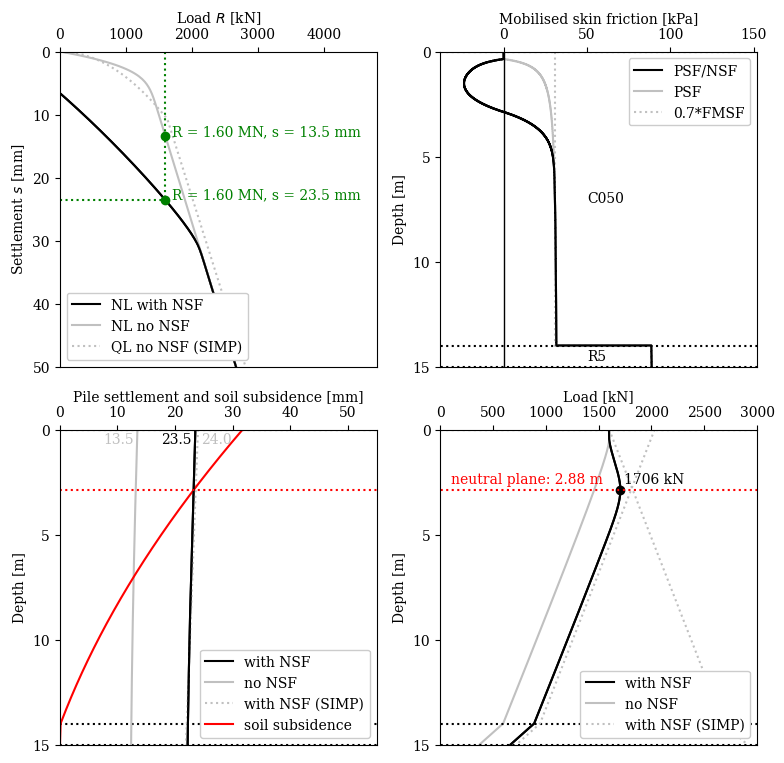

In [ ]:
## PLOT
################################################################################

fig, axs = plt.subplots(2, 2, figsize=(9, 9))

axs[0, 0].plot(R_s_nl_NSF, s_nl_NSF, label='NL with NSF', color = 'black')
# axs[0, 0].plot(Q_b_NSF, sbase, ':', color = 'black')
axs[0, 0].plot(R_s_nl, s_nl, label='NL no NSF', color = 'silver')
# axs[0, 0].plot(Q_b, sbase, ':', color = 'silver')
axs[0, 0].plot(R_rs, s, ':', color = 'silver', label='QL no NSF (SIMP)')
# axs[0, 0].plot([0, beta*Ry, Rbu], [0, sy, 25], ':', color = 'silver')

axs[0, 0].plot(R_s_nl_NSF, s_nl_NSF, color = 'black')

axs[0, 0].plot([R_user], [s_nl_use], 'o', color = 'green')
text= "R = {:.2f} MN, s = {:.1f} mm".format(R_user/1000, s_nl_use)
axs[0, 0].annotate(text, (R_user+100, s_nl_use-0.2), color='green')
axs[0, 0].plot([R_user], [s_nl_NSF_use], 'o', color='green')
text= "R = {:.2f} MN, s = {:.1f} mm".format(R_user/1000, s_nl_NSF_use)
axs[0, 0].annotate(text, (R_user+100, s_nl_NSF_use-0.2), color='green')
axs[0, 0].plot([R_user, R_user], [0, s_nl_NSF_use], ':', color='green')
axs[0, 0].plot([0, R_user], [s_nl_NSF_use, s_nl_NSF_use], ':', color='green')



axs[0, 0].set_xlabel(r'Load $R$ [kN]')
axs[0, 0].set_ylabel(r'Settlement $s$ [mm]')
# axs[0, 0].set_title(r'Load-settlement curves')

axs[0, 0].legend(loc='lower left', framealpha=1)

# axs[0, 0].set_xlim([0, np.round(Ru+2000, decimals = -2)])
axs[0, 0].set_xlim([0, 4800])
# axs[0, 0].set_ylim([25+s_nl_NSF[0], 0])
axs[0, 0].set_ylim([50, 0])
# axs[0, 0].grid(True)

axs[0, 1].plot(qs_user2, z_q, 'black', label='PSF/NSF')
axs[0, 1].plot(qs_user, z_q, 'silver', label='PSF')
axs[0, 1].plot(qsi_plot*0.7, z_plot, color = 'silver', linestyle = 'dotted', label='0.7*FMSF')
axs[0, 1].plot(qs_user2, z_q, 'black')

axs[0, 1].set_ylim([L, 0])
axs[0, 1].set_xlim([-0.3*np.max(qsi_plot), 1.2*np.max(qsi_plot)])
axs[0, 1].set_xlabel(r'Mobilised skin friction [kPa]')
axs[0, 1].set_ylabel(r'Depth [m]')
# axs[0, 1].set_title(r'Mobilised skin friction')

for index, value in enumerate(z_inter):
  axs[0, 1].plot([-1e6, 1e6], [value, value], ':k')

for index, value_height_i in enumerate(height_i):
  value_Di = Di[index]
  text = soil_i[index]
  axs[0, 1].annotate(text, (50, value_Di+0.2))

axs[0, 1].axvline(x=0, color='k', lw=1)

axs[0, 1].legend(loc='upper right', framealpha=1)

for index, value in enumerate(z_inter):
  axs[1, 0].plot([-1e6, 1e6], [value, value], ':k')

axs[1, 0].plot(s_nl_user2, z_cut, 'black', label='with NSF')
text= r'{:.1f}'.format(s_nl_user2[0])
axs[1, 0].annotate(text, (s_nl_user2[0]-6, 0.9*0.75), color='black')

axs[1, 0].plot(s_nl_user, z_cut, 'silver', label='no NSF')
text= r'{:.1f}'.format(s_nl_user[0])
axs[1, 0].annotate(text, (s_nl_user[0]-6, 0.9*0.75), color='silver')

axs[1, 0].plot([val_s, val_s/Rk], [0, L], color = 'silver', linestyle = 'dotted', label = 'with NSF (SIMP)')
text= r'{:.1f}'.format(val_s)
axs[1, 0].annotate(text, (val_s+0.5, 0.9*0.75), color='silver')

axs[1, 0].plot(s_soil, z_soil, 'r', label='soil subsidence')

axs[1, 0].plot(s_nl_user2, z_cut, 'black')

axs[1, 0].set_xlim([0, 55])
axs[1, 0].set_ylim([L, 0])
axs[1, 0].set_xlabel(r'Pile settlement and soil subsidence [mm]')
axs[1, 0].set_ylabel(r'Depth [m]')
# axs[1, 0].set_title(r'Pile settlement and soil subsidence')

axs[1, 0].plot([-1e6, 1e6], [z_max,z_max], ':', color='red')

axs[1, 0].legend(loc='lower right', framealpha=1)

axs[1, 1].plot(R_s_nl_user2, z_cut, 'black', label='with NSF')
axs[1, 1].plot([R_max], [z_max], 'ok')
text= r'{:.0f} kN'.format(R_max)
axs[1, 1].annotate(text, (R_max+30, z_max-0.3), color='black')
axs[1, 1].plot(R_s_nl_user, z_cut, 'silver', label='no NSF')

axs[1, 1].plot([-1e6, 1e6], [z_max,z_max], ':', color='red')
text= r'neutral plane: {:.2f} m'.format(z_max)
axs[1, 1].annotate(text, (100, z_max-0.3), color='red')

for index, value in enumerate(z_inter):
  axs[1, 1].plot([-1e6, 1e6], [value, value], ':k')

axs[1, 1].set_xlim([0, 3000])
axs[1, 1].set_ylim([L, 0])
axs[1, 1].set_xlabel(r'Load [kN]')
axs[1, 1].set_ylabel(r'Depth [m]')
# axs[1, 1].set_title(r'Distributions of forces acting on pile')
axs[1, 1].plot(resistance, z_inter, color = 'silver', linestyle = 'dotted')
axs[1, 1].plot(np.array(load), z_inter, color = 'silver', linestyle = 'dotted', label = 'with NSF (SIMP)')
axs[1, 1].plot(R_s_nl_user2, z_cut, 'black')
axs[1, 1].legend(loc='lower right', framealpha=1)

axs[0, 0].xaxis.tick_top()
axs[1, 0].xaxis.tick_top()
axs[0, 1].xaxis.tick_top()
axs[1, 1].xaxis.tick_top()

axs[0, 0].xaxis.set_label_position('top')
axs[1, 0].xaxis.set_label_position('top')
axs[0, 1].xaxis.set_label_position('top')
axs[1, 1].xaxis.set_label_position('top')

axs[1, 0].set_yticks([0, 5, 10, 15])
axs[0, 1].set_yticks([0, 5, 10, 15])
axs[1, 1].set_yticks([0, 5, 10, 15])

plt.savefig('Ex1_2.pdf')
plt.show()
